In [1]:
import numpy as np
import stochasticTN as stn
import time
import matplotlib.pyplot as plt
from typing import Optional

# Examples

In this notebook we provide some examples of how to use the stochasticTN package for optimizing an MPS representing the probability distribution over all configurations of a bit-string. The examples are tailored to computing observables for the one-dimensional contact process (or the SIS model). Details are described in https://arxiv.org/abs/2305.06815

## stochasticTN package

- `mps.py` defines the MPS class
- `mpo.py` defines the MPO class
- `stochasticDMRG.py` defines the DMRG class for the variational optimization of an MPS given a (tilted) generator as MPO 
- `operations.py` contains several functions for contacting MPS objects
- `linalg.py` contains custom linear algebra functions (so far only svd)
- `information_measures.py` contains functions for computing entropic measures from the MPS objects 

To optimize an MPS from a random initial state, first initialize the random MPS of size N with bond dimension D using `stn.randomMPS(N,D)`

In [2]:
N=50
D=20
mps = stn.randomMPS(N, D)

Next, define the (tilted) generator at a specific value of $\lambda$ = `r` as an MPO object. Here we first look at the Markov generator at `s=0` with boundry driving and driving rate `omega = 1` 

In [3]:
r = 2
s = 0
mpo = stn.SIS_MPO(N, r, s, driving = 'boundary', omega = 1)

Then, initiate the variational optimization and run the optimization for double site update. Whenever `s=0`, the algorithm keeps sweeping until the global density in the chain has converged within the value set by `accuracy`. When $s\neq0$ the convergence criteria is set to the variance of the tilted generator, which should vanish when the MPS is closest to optimal.

In [4]:
env = np.ones((1,1,1))
dmrg = stn.DMRG(mps, mpo, env, env)

In [5]:
dens, vardens, err, converged = dmrg.run_double_site_dmrg(accuracy=1e-8, Dmax = 500, cutoff=1e-14)

VarMPS sites=(0,1)/50: optimized E=-3.210181043148212e-13, D = 2,  truncated SVs = 0   271465716910525e-14  3   
r = 2.000000,    n =  3,    FE = 0.612524721,    delFE = 0.012354931    tps = 42.77s    <D>= 125.18   maxD = 197


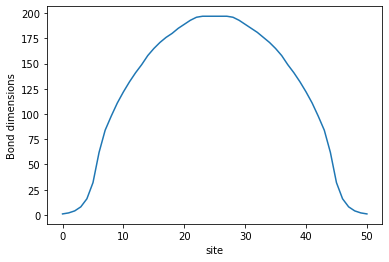

In [6]:
plt.plot(mps.bond_dimensions)
plt.ylabel("Bond dimensions")
plt.xlabel("site")
plt.show()

### Gap expectation values

With the MPS optimized in the NESS for $\lambda  = 2$, we can compute observables, such a the expectation value of observing a gap of length $0\leq k<N-1$ in the chain.

In [7]:
norm = mps.norm()
expgap = np.zeros(N-1)

for k in range(N-1):
    gapmpo = stn.gapMPO(N, k)
    expgap[k] = stn.MPOexpectation(mps, gapmpo)/norm

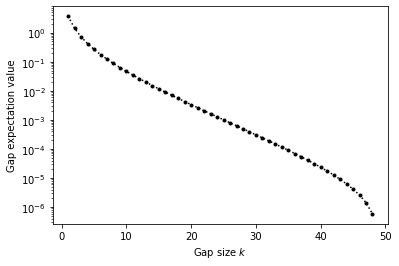

In [10]:
gaplen = [k for k in range(N-1)]
plt.semilogy(gaplen[1:],expgap[1:], 'k.:')
plt.xlabel(r'Gap size $k$')
plt.ylabel(r'Gap expectation value')
plt.show()

## MPS methods to compute the SCGF

Below we define a function which computes for a fixed MPS length $N$ and transmission rate $\lambda =$`r` the leading eigenvector of the tilted generator, from which we can extract various quantities of interest as a function of the tilting parameter `s`. It computes from this:

- the scaled cumulant generating function (scgf) $\Theta(s)$
- the variance of the tilted generator (${\rm Var}[\Theta(s)] = \langle \mathbf{1}| \tilde{W}(s)^2 |\Psi(s) \rangle - \Theta(s)^2$). This gives an indication of the accuracy of the result
- the density in the chain
- the variance in the density in the chain
- the second Renyi entropy
- the second Renyi entanglement entropy between the two halves of the chain
- the second Renyi mutual information between the two halves of the chain
 

In [14]:
def run_stochacticDMRG(mps, r, slist, 
                       driving = 'boundary', omega = 1, double_site = True,
                       MaxSweeps = 12, accuracy = 1e-8, tol = 1e-11, Dmax = 180, cutoff = 1e-16):
    st = time.time()
    res = np.zeros([len(slist),12])
    density_mpo = stn.occupancy_MPO(N)
    for i, s in enumerate(slist):
        mpo = stn.SIS_MPO(N,r,s)
        envs = np.ones((1,1,1))
        dmrg = stn.DMRG(mps,mpo,envs,envs)
        mps.position(0)
        scgf, variance, err, converged = dmrg.run_double_site_dmrg(1, accuracy, tol = 1e-6, Dmax = 200, cutoff=1e-12)
        
        if double_site:
            mps.position(N//2)
            scgf, variance, err, converged = dmrg.run_double_site_dmrg(MaxSweeps-1, accuracy,tol,
                                                              Dmax, cutoff)
        else:
            mps.position(N//2)
            scgf, variance, err, converged = dmrg.run_single_site_dmrg(MaxSweeps-1, accuracy,tol,
                                                              Dmax, cutoff)
            
        norm = mps.norm()
        D = max(mps.bond_dimensions)
        density = stn.MPOexpectation(mps, density_mpo, 'stoch')/norm/N
        vardensity = 1/N**2*stn.MPOvariance(mps, density_mpo, 'stoch')/norm-density**2
        
        re = stn.second_Renyi_entropy(mps,norm)
        sree = stn.second_Renyi_EE(mps,N//2-1, norm = norm, side = 'L')
        srmi = stn.second_Renyi_MI(mps,N//2-1, SRE = re, SREEleft = sree, norm = norm)
        
        res[i] = [N, D, r, s, scgf, variance, density, vardensity, err, re, sree, srmi]
    et = time.time()
    compt = et -st
    print("N =%3d, D = %2d, r = %.2f, finished in %.2fs" %(N,D,r,compt))
    return res

In [15]:
N = 40
r = 2
D = 60
slist = np.append(np.logspace(1,-4,81),-np.logspace(-4,1,81))

In [ ]:
mps = stn.randomMPS(N,D)
res = run_stochacticDMRG(mps, r, slist, double_site=True, tol=1e-11, cutoff=1e-14, Dmax = 500)

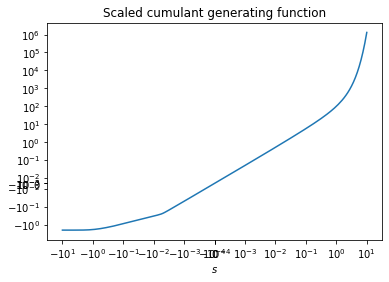

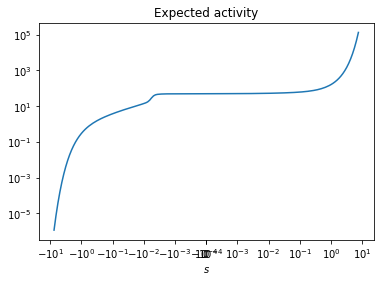

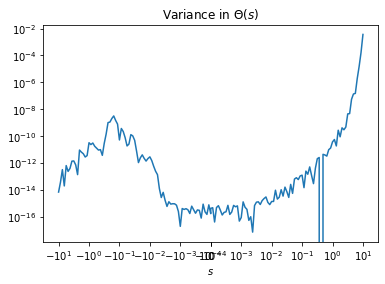

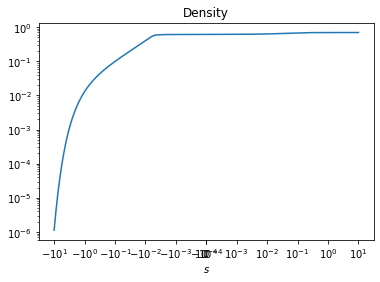

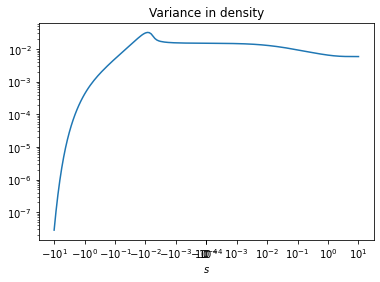

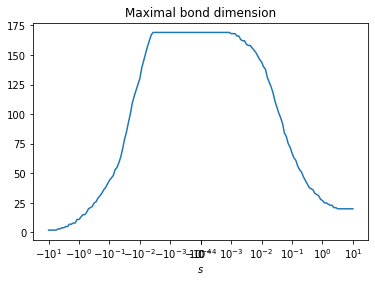

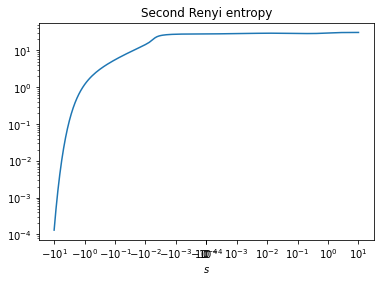

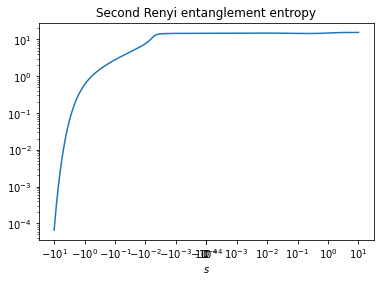

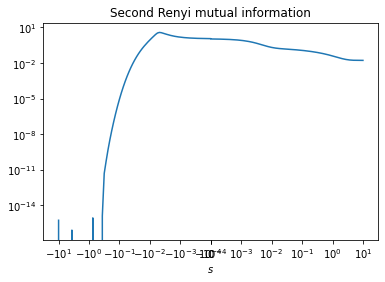

In [17]:
scgf= res[:,4]
exp = np.gradient(scgf, slist, axis=0)

plt.plot(slist,scgf)
plt.title("Scaled cumulant generating function")
plt.xscale('symlog',linthresh=1e-4,linscale=0.001)
plt.yscale('symlog',linthresh=scgf[80],linscale=0.001)
plt.xlabel(r'$s$')
plt.show()

plt.plot(slist[2:-2],exp[2:-2])
plt.title('Expected activity')
plt.xscale('symlog',linthresh=1e-4,linscale=0.001)
plt.yscale('log')
plt.xlabel(r'$s$')
plt.show()

plt.semilogy(slist,res[:,5])
plt.title('Variance in $\Theta(s)$')
plt.xscale('symlog',linthresh=1e-4,linscale=0.001)
plt.xlabel(r'$s$')
plt.show()

plt.plot(slist,res[:,6])
plt.title('Density')
plt.xscale('symlog',linthresh=1e-4,linscale=0.001)
plt.yscale('log')
plt.xlabel(r'$s$')
plt.show()

plt.semilogy(slist,res[:,7])
plt.title('Variance in density')
plt.xscale('symlog',linthresh=1e-4,linscale=0.001)
plt.xlabel(r'$s$')
plt.show()

plt.plot(slist,res[:,1])
plt.xscale('symlog',linthresh=1e-4,linscale=0.001)
plt.xlabel(r'$s$')
plt.title('Maximal bond dimension')
plt.show()

plt.semilogy(slist,res[:,9])
plt.xscale('symlog',linthresh=1e-4,linscale=0.001)
plt.xlabel(r'$s$')
plt.title('Second Renyi entropy')
plt.show()

plt.semilogy(slist,res[:,10])
plt.xscale('symlog',linthresh=1e-4,linscale=0.001)
plt.xlabel(r'$s$')
plt.title('Second Renyi entanglement entropy')
plt.show()

plt.semilogy(slist,res[:,11])
plt.xscale('symlog',linthresh=1e-4,linscale=0.001)
plt.xlabel(r'$s$')
plt.title('Second Renyi mutual information')
plt.show()